# Using FNO Architectures to solve Inverse Problems

### Intro to Inverse Problems
***What is an inverse problem?***\
An inverse problem is a problem in which one seeks to determine the causes or inputs that gave rise to observed or measured outputs. In other words, given some observed or measured data, the inverse problem involves determining the unknown inputs or causes that produced the observed outputs.


***What is an ill-posed problem?*** \
In mathematics and science, an ill-posed problem is a problem that does not satisfy one or more of the three conditions of well-posedness: 
* existence - a solution must exist
* uniqueness - every solution must be unique
* stability of the solution - a small error in the input data or parameters should not lead to a large error in the solution.

***What is an ill-posed inverse problem?***\
An ill-posed inverse problem is a type of inverse problem that is also ill-posed. In other words, the problem of inferring the unknown inputs or causes that gave rise to observed or measured outputs does not satisfy one or more of the conditions of well-posedness, such as existence, uniqueness, and stability of the solution



### What are some examples in finance?

Inverse problems have many applications in finance, where the goal is often to infer the unknown causes or inputs that give rise to observed market data. Here are some examples of inverse problems in finance:

* Option pricing: Inverse problems can be used to determine the unknown parameters of a financial model, such as the volatility of the underlying asset, from the prices of traded options. This involves inverting the Black-Scholes equation, which relates the price of an option to the underlying asset price, volatility, interest rate, and time to expiration.

* Portfolio optimization: Inverse problems can be used to determine the optimal allocation of assets in a portfolio from observed market data, such as historical prices and returns. This involves inverting a mathematical model that relates the expected return and risk of a portfolio to its asset allocation.

* Credit risk modeling: Inverse problems can be used to determine the unknown default probabilities of borrowers from observed market data, such as credit spreads and credit ratings. This involves inverting a model that relates the default probability of a borrower to its credit rating, maturity, and other factors.

Solving these inverse problems in finance often involves using advanced mathematical techniques, such as optimization, statistical inference, and machine learning. The solutions can provide valuable insights into market dynamics, risk management, and investment strategies


# Portfolio Optimisation

Given a set of observed market data, such as historical prices and returns, and a mathematical model that relates the expected return and risk of a portfolio to its asset allocation, the goal is to determine the optimal allocation of assets in the portfolio that gave rise to the observed data.

Formally, let $R$ be an $n$-dimensional vector of expected returns of $n$ assets, and let $\Sigma$ be an $n \times n$ covariance matrix of asset returns. Let $w$ be an $n$-dimensional vector of asset weights, where $w_i$ represents the weight of the $i$-th asset in the portfolio. The expected return and risk of the portfolio can be defined as:

\begin{align*}
\mu &= w^T R \
\sigma^2 &= w^T \Sigma w \
\end{align*}

The goal of portfolio optimization is to find the optimal vector of asset weights $w^*$ that maximizes the expected return of the portfolio subject to a constraint on its risk, such as a maximum variance or a maximum drawdown:

\begin{align*}
\text{maximize} \quad & \mu(w) = w^T R \
\text{subject to} \quad & \sigma^2(w) \leq \sigma^2_{\max} \
\end{align*}

where $\sigma^2_{\max}$ is the maximum allowed risk of the portfolio.

The inverse problem in portfolio optimization is to determine the vector of asset weights $w^*$ that gave rise to the observed market data, such as historical returns, by inverting the mathematical model that relates the expected return and risk of the portfolio to its asset allocation. This involves solving the above optimization problem for $w^*$, given the observed market data and the maximum allowed risk of the portfolio.


In [ ]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tabulate import tabulate

torch.manual_seed(0)
np.random.seed(0)

: 

In [1]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
batch_size = 10
learning_rate = 0.001

epochs = 20
step_size = 50
gamma = 0.5

modes = 5
width = 64

weight_decay=1e-4

### Model Metrics
We generated a set of basic image metrics which include RMSE (root-mean-square error), PSNR (peak signal-to-noise ratio) and SSIM (structural similiarity index). These metrics provide a complete overview of our reconstruction results:

 $RMSE = \sqrt{MSE} =  \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{\text{predicted} - \text{actual} }{\sigma_i}\Big)^2}}$ 
 
 
 ${PSNR} = 10\log_{10} \frac{{MAX}^2_I}{MSE}$

$ SSIM = \frac{(2\mu_x\mu_y + C_1) + (2 \sigma _{xy} + C_2)}{(\mu_x^2 + \mu_y^2+C_1) (\sigma_x^2 + \sigma_y^2+C_2)} $

These are standard image quaity and image reconstruction metrics. 

In [3]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()

        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", round(model_rms,5), round(std_rms,5), sep="---")
    print("PSNR: ", round(model_psnr,5), round(std_psnr,5), sep="---")
    print("SSIM: ", round(model_ssim,5), round(std_ssim,5), sep="---")
    #print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    # average values
    'model_rms': [round(model_rms,5),round(std_rms,5)],
    'model_psnr': [round(model_psnr,5),round(std_psnr,5)],
    'model_ssim': [round(model_ssim,5),round(std_ssim,5)]
    }
    return output 

### Architectures and Training Algorithm

In [23]:
# Multi-Layer Perceptron
###################################

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
       
        self.fc0 = nn.Linear(64, 400)
        self.fc1 = nn.Linear(400, 256)

    def forward(self, x):       
        x = self.fc0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = F.sigmoid(x)
        return x

In [5]:
# Convoluational Neural Network
###################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        self.fc0 = nn.Linear(64, 256)

        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0)
        #self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=5//2),
    def forward(self, x):
       
        x = self.fc0(x)
        x = x.reshape(x.shape[0],1,16,16)

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)        
        x = F.sigmoid(x)
        return x

In [6]:
#   DEFINING THE TOP 2D FOURIER LAYER
#####################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        #print('input',input.shape)
        #print('weights',weights.shape)
        #print("bixy,ioxy->boxy")
        R_out = torch.einsum("bixy,ioxy->boxy", input, weights)
        #print(R_out.shape)
        return R_out

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        #print('what is out_ft', out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [7]:
# FNO Architecture
####################################### MODELS ###############################
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [8]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", round(total_time,2), sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": round(total_time,2),
    "model": model
    }
    return output 

### Loading Raw Data

The data is generated by a 3 step process:
* Random elliptical 16 by 16 images are created
* These images are mapped into a circlular domain. (This is our solution space)
* The forward problem is solved using FEM and only the boundary values are kept. (This is our measurement space) 


Our task is to reconstruct the solution space from our set of boundary values that defines our measurement space.

In [9]:
raw_data = scipy.io.loadmat('./datasets/complete_data')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

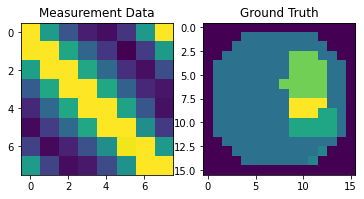

In [10]:
test_num = 423

f, axarr = plt.subplots(1,2)
axarr[0].title.set_text('Measurement Data')
axarr[0].imshow(np.reshape(mes[test_num],(8,8)))
axarr[1].title.set_text('Ground Truth')
axarr[1].imshow(np.reshape(sol[test_num],(16,16)))

# Investigating Each Architectures

### FNO : Data Loading, Training and Results

<img src= https://zongyi-li.github.io/neural-operator/img/fourier_full_arch5.png width="800">


In [11]:
# DATA LOADING
############################## DATA LOADING ########################################

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))

# dimensions of solution space
y_dim1 = 16
y_dim2 = 16

# dimensions of measurement space
x_dim2 = 8     # no of detectors
x_dim1 = int(mes.shape[1]/x_dim2)

def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_test = y_test.reshape(y_test.shape[0],y_dim1,y_dim2,1)
y_train = y_train.reshape(y_train.shape[0],y_dim1,y_dim2,1)

X_test = X_test.reshape(X_test.shape[0], x_dim1,x_dim2,1)
X_train = X_train.reshape(X_train.shape[0], x_dim1,x_dim2,1)

train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print(X_train.shape, y_train.shape)

fno_loader = test_loader

torch.Size([8000, 8, 8, 1]) torch.Size([8000, 16, 16, 1])


1664132
0 17.20417179982178 0.1592705829963088 0.11922595232725143
1 12.73366990010254 0.11709969457983971 0.13600723749399185
2 12.637784100137651 0.11155149962008 0.11118880397081375
3 12.626322399824858 0.10566176649183034 0.10275854608416557
4 12.751352499937639 0.10452664053440094 0.10105048424005508
5 12.853591600200161 0.10211546853929758 0.09646889507770538
6 12.63464399985969 0.09864862497895956 0.1006101821064949
7 13.101237999973819 0.09722524707764388 0.0986832399070263
8 12.426132700173184 0.09459888093918561 0.09748269927501678
9 12.185132100014016 0.0928398402929306 0.09350768527388573
10 11.397312700049952 0.0917500336393714 0.08933595004677773
11 11.484758199891075 0.08947689986228943 0.08999314484000207
12 11.534499199828133 0.08808314855396747 0.08751248297095299
13 11.458743199938908 0.08682271344959736 0.08893716967105865
14 11.960575700039044 0.08577762841433287 0.08577898299694062
15 11.472803700016811 0.08421389795839787 0.08391909995675087
16 11.865210900083184

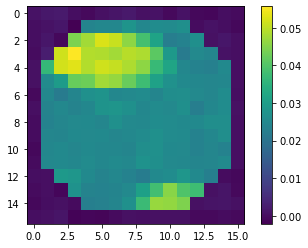

In [12]:
# FNO RESULTS
############################################################################

model = FNO2d(modes, modes, width).cuda()
print(count_params(model))
out = train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma)
fno_out = out

fno_model = out.get("model")
fno_metrics = model_metrics(fno_model,test_loader,ntrain)

# TEST PREDICTIONS
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
fno_model.eval()
predicted = np.reshape(fno_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

### MLP : Data Loading, Training and Results

<img src= https://images.deepai.org/glossary-terms/49157de013394ab7a36022759a55b6aa/multipercep.jpg width="600">


In [24]:
# DATA LOADING
############################## DATA LOADING ########################################
X, y = convert_data(mes, sol)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print('training: measurement', X_train.shape, 'solution', y_train.shape)
print('test: measurement', X_test.shape, 'solution', y_test.shape)

mlp_loader = test_loader

training: measurement torch.Size([8000, 64]) solution torch.Size([8000, 256])
test: measurement torch.Size([2000, 64]) solution torch.Size([2000, 256])


128656
0 1.986377000110224 0.8070970054268837 0.39329005897045133
1 1.810271699912846 0.24731577548384667 0.18469045442342757
2 1.812677700072527 0.1813589796870947 0.17056835722923278
3 1.8013470000587404 0.16187449057400227 0.16871476370096206
4 1.8306665001437068 0.1529636677056551 0.14191934376955032
5 1.832365999929607 0.1461531184911728 0.14370735955238342
6 1.7979152000043541 0.14287474816292525 0.14421687030792235
7 1.8016540000680834 0.13976393610984086 0.13156856656074523
8 1.7922871999908239 0.13887203440070153 0.13600545275211334
9 1.8100824998691678 0.13570415204018355 0.1293416151702404
10 1.8370844998862594 0.13454272678494453 0.14831687378883363
11 1.84935069992207 0.13550071630626917 0.13856675738096239
12 1.809207099955529 0.13304225544631482 0.13774815583229064
13 1.806006700033322 0.13380468736588955 0.1291870066523552
14 1.8059318999294192 0.1312412896975875 0.13820464450120926
15 1.7736682000104338 0.1320210026204586 0.12105355405807496
16 1.8008991999085993 0.129

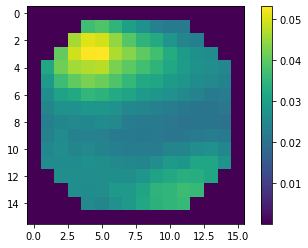

In [25]:
model = MLP().cuda()
print(count_params(model))
out = train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma)
mlp_out = out

mlp_model = out.get("model")
mlp_metrics = model_metrics(mlp_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
mlp_model.eval()
predicted = np.reshape(mlp_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

### CNN DATA AND RESULTS

<img src= https://miro.medium.com/max/1400/1*hYN6b13CKaTN1jnafkq5KQ.jpeg width="800">

In [16]:
# we are solving the inverse problem, so going from measurements, to solutions

X_dim = X_train.shape[1]
y_dim = y_train.shape[1]

X_train = X_train.reshape(ntrain,1,X_dim)
X_test = X_test.reshape(ntest,1,X_dim)

y_train = y_train.reshape(ntrain,1,16,16)
y_test = y_test.reshape(ntest,1,16,16)

train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('training data: measurements', X_train.shape, 'solution', y_train.shape)
print('training data: measurements', X_test.shape, 'solution', y_test.shape)

cnn_loader = test_loader

training data: measurements torch.Size([8000, 1, 64]) solution torch.Size([8000, 1, 16, 16])
training data: measurements torch.Size([2000, 1, 64]) solution torch.Size([2000, 1, 16, 16])


20097


c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 2.9627091998700052 1.035846793115139 0.33509510111808777
1 2.6685144000221044 0.2596756193190813 0.25183445715904235
2 2.665034400066361 0.20780407597124576 0.21473931616544722
3 2.662552800029516 0.19540229423344135 0.18310280853509903
4 2.7697596999350935 0.18049328964948655 0.2266120045185089
5 2.7844209999311715 0.17823737663030625 0.16220143711566926
6 2.841749900020659 0.16613220041990281 0.15972183960676192
7 2.5949973999522626 0.16129693859815597 0.15172731399536132
8 2.7763354000635445 0.15572086136043073 0.15058891201019287
9 2.7495790999382734 0.15251257929205894 0.15409102934598923
10 2.6610249001532793 0.14820320639014245 0.1429876549243927
11 2.6246634998824447 0.1452964989989996 0.14374864304065704
12 2.721792400116101 0.14303613174706697 0.1353724120259285
13 2.805641599930823 0.14292509864270686 0.13579631766676903
14 2.757719799876213 0.1403753473982215 0.13859658521413804
15 2.630994599778205 0.1386580484956503 0.13182169273495675
16 2.7740274001844227 0.1386329826

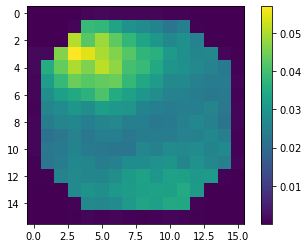

In [21]:
# SIGMA - TEST NETWORK
############################################################################

model = CNN().cuda()
print(count_params(model))
out = train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma)
cnn_out = out

cnn_model = out.get("model")
cnn_metrics = model_metrics(cnn_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
cnn_model.eval()
predicted = np.reshape(cnn_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

### Direct Comparison Between Models

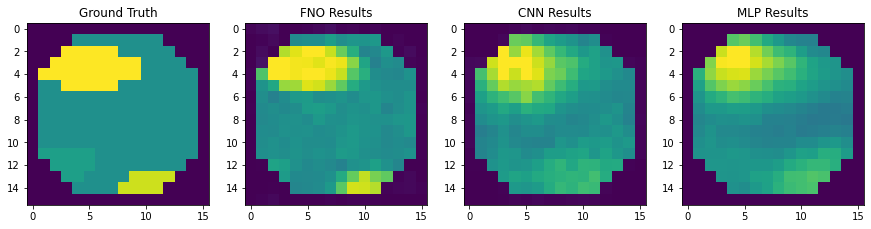

In [26]:
test_num = 423

### GROUND TRUTH, FNO, MLP, CNN


f, axarr = plt.subplots(1,4, figsize=(15, 15))

truth_out = test_loader.dataset[test_num][1]
axarr[0].title.set_text('Ground Truth')
axarr[0].imshow(np.reshape(truth_out.numpy(),(16,16)), vmin=0, vmax=0.05)

K = torch.unsqueeze(fno_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(fno_model(K).detach().cpu().numpy(),(16,16))
axarr[1].title.set_text('FNO Results')
axarr[1].imshow(predicted, vmin=0, vmax=0.05)

K = torch.unsqueeze(cnn_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(cnn_model(K).detach().cpu().numpy(),(16,16))
axarr[2].title.set_text('CNN Results')
axarr[2].imshow(predicted, vmin=0, vmax=0.05)


K = torch.unsqueeze(mlp_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(mlp_model(K).detach().cpu().numpy(),(16,16))
axarr[3].title.set_text('MLP Results')
axarr[3].imshow(predicted, vmin=0, vmax=0.05)

In [30]:
table = [['Architecture', 'Time (s)', 'RMSE (mean,std)', 'PSNR (mean,std)', 'SSIM (mean,std)', 'Training Time (s)'],
         ['FNO', fno_out.get("training_time"), fno_metrics.get('model_rms'), fno_metrics.get('model_psnr'), fno_metrics.get('model_ssim')], 
         ['CNN', cnn_out.get("training_time"), cnn_metrics.get('model_rms'), cnn_metrics.get('model_psnr'), cnn_metrics.get('model_ssim')], 
         ['MLP', mlp_out.get("training_time"), mlp_metrics.get('model_rms'), mlp_metrics.get('model_psnr'), mlp_metrics.get('model_ssim')]]


print(tabulate(table, headers='firstrow'))

Architecture      Time (s)  RMSE (mean,std)     PSNR (mean,std)      SSIM (mean,std)
--------------  ----------  ------------------  -------------------  ------------------
FNO                 247.33  [0.00222, 0.00104]  [27.94514, 2.91786]  [0.92098, 0.02336]
CNN                  54.5   [0.00361, 0.00146]  [23.09314, 2.25803]  [0.80454, 0.04876]
MLP                  36.41  [0.0034, 0.00144]   [23.67901, 2.37488]  [0.82297, 0.04106]


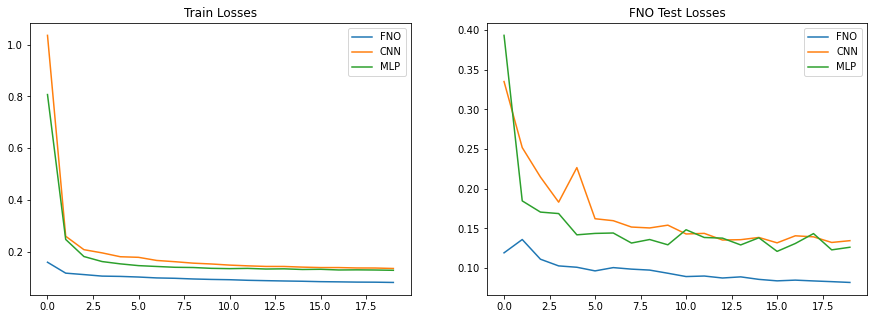

In [59]:
f, axarr = plt.subplots(1,2, figsize=(15, 5))

#FNO LOSSES
axarr[0].title.set_text('Train Losses')
axarr[0].plot(fno_out.get("train_losses"), label='FNO')
axarr[0].plot(cnn_out.get("train_losses"), label='CNN')
axarr[0].plot(mlp_out.get("train_losses"), label='MLP')
axarr[0].legend()
#axarr[0,0].set_ylim([0.08, 0.16])


axarr[1].title.set_text('Test Losses')
axarr[1].plot(fno_out.get("test_losses"), label='FNO')
axarr[1].plot(cnn_out.get("test_losses"), label='CNN')
axarr[1].plot(mlp_out.get("test_losses"), label='MLP')
axarr[1].legend()
#axarr[0,1].set_ylim([0.08, 0.16])
